In [ ]:
# Measuring the jet stream from flight data
## using flight data from http://stat-computing.org/dataexpo/2009/

In [39]:
from __future__ import division
import numpy as np
import numpy.linalg
import datetime
import pymysql
import pymysql.cursors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from operator import itemgetter

In [476]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (27.78, 14.46)

# first, let's pull the airport data we'll use and make some maps

In [3]:
## function to query the database
def sqlExec(query):
    """Given file name, reads input file and stores data"""
    db = pymysql.connect(user="root", host="localhost", passwd="", db="flight_data", cursorclass=pymysql.cursors.DictCursor)
    with db:
        cur = db.cursor()
        cur.execute(query)
        tables = cur.fetchall()
        return tables

## SQL databases built from .csv files (from website at the top)

## airports database fields:
## Code, Airport, City, State, Country, Latitude, Longitude

In [195]:
## a set of airports 

## large, busy airports: approximately 20% of all flights are between these airports
# airports = ["SEA","PDX","FAR","BOI","SFO","LAX","ELP","DFW","IAH","PHX","LAS","DEN","MSP","MKE","ORD","STL","DTW","PIT","IAD","JFK","BOS","ATL","CLT","MIA"]

## all continental US airports which had > 100,000 enplanements in 2014
## 90% of all flights are between these airports
## data pulled from FAA (http://www.faa.gov/airports/planning_capacity/passenger_allcargo_stats/passenger/)
infile = open("data/airports_enplanements.txt", "r")
airportdata = []
for line in infile:
    airportdata.append(line[:-1].split('\t'))
airports = [adata[1] for adata in airportdata]
airport_passengers = {adata[1] : eval(adata[2]) for adata in airportdata}
sqlsetairports = "(\""+'\", \"'.join(airports)+"\")"

In [191]:
## get the latitude and longitude of each airport
airportrows = sqlExec("SELECT Code,Latitude,Longitude FROM airports WHERE Code IN "+sqlsetairports)
## put this into a dictionary
airportcoords = {}
for row in airportrows:
    airportcoords[row["Code"]] = [row["Longitude"], row["Latitude"]]

In [375]:
## function to compute the geodesic distance (in miles) between two latitude, longitude pairs
def geodesicDist(coords1, coords2):
    """Computes geodesic distance between two latitude, longitude points, in miles.  Uses Earth radius = 3963 miles.  Assumes latitudes and longitudes are in degrees."""
    [long1, lat1] = coords1
    [long2, lat2] = coords2
    rEarth = 3963.
    ## convert latitudes to polar angles (radians)
    theta1 = 0.5 * np.pi - (np.pi / 180.) * lat1
    theta2 = 0.5 * np.pi - (np.pi / 180.) * lat2
    ## convert longitudes radians
    phi1 = (np.pi / 180.) * long1
    phi2 = (np.pi / 180.) * long2
    ## create unit vectors to each point
    unitvec1 = np.array([ np.sin(theta1) * np.cos(phi1), np.sin(theta1) * np.sin(phi1), np.cos(theta1) ])
    unitvec2 = np.array([ np.sin(theta2) * np.cos(phi2), np.sin(theta2) * np.sin(phi2), np.cos(theta2) ])
    ## calculate distance
    return rEarth * np.arccos( np.dot(unitvec1, unitvec2) )

In [226]:
## parametric function for a great circle between two longitude, latitude points
def greatCircleFunc(coords1, coords2, t):
    """Gives parametric formula for the great circle between two latitude, longitude points. Returns [latitude, longitude] in degrees."""
    [long1, lat1] = coords1
    [long2, lat2] = coords2
    ## convert latitudes to polar angles (radians)
    theta1 = 0.5 * np.pi - (np.pi / 180.) * lat1
    theta2 = 0.5 * np.pi - (np.pi / 180.) * lat2
    ## convert longitudes radians
    phi1 = (np.pi / 180.) * long1
    phi2 = (np.pi / 180.) * long2
    ## create unit vectors to each point
    unitvec1 = np.array([ np.sin(theta1) * np.cos(phi1), np.sin(theta1) * np.sin(phi1), np.cos(theta1) ])
    unitvec2 = np.array([ np.sin(theta2) * np.cos(phi2), np.sin(theta2) * np.sin(phi2), np.cos(theta2) ])
    ## angle between the two points
    tau = np.arccos( np.dot(unitvec1, unitvec2) )
    ## parametric terms
    A = np.sin((1 - t)*tau) / np.sin(tau)
    B = np.sin(t*tau) / np.sin(tau)
    ## compute latitude, longitude
    xt = A * np.sin(theta1) * np.cos(phi1) + B * np.sin(theta2) * np.cos(phi2)
    yt = A * np.sin(theta1) * np.sin(phi1) + B * np.sin(theta2) * np.sin(phi2)
    zt = A * np.cos(theta1) + B * np.cos(theta2)
    longt = (180. / np.pi) * np.arctan2(yt, xt)
    latt = (180. / np.pi) * np.arctan2(zt, np.sqrt(xt*xt + yt*yt))
   
    return [longt, latt]

In [155]:
## we use a continental US map in mercator coordinates as a background
## the image size is 2000 by 1041 pixels
## coordinates are [0, 2000] in longitude, [1041, 0] in latitude
img=mpimg.imread('maps/USmap_big.png')

In [160]:
## define latitude and longitude coordinates for the map
## latitude (x): [-125.5, -66.5] -> [0, 2000]
## longitude (y): [24.2, 49.8] -> [1041, 0]
def map_coords(coords):
    """Returns coordinates in terms of pixels on the map, given longitude and latitude."""
    # longitude
    x = (2000./59.) * (125.5 + coords[0])
    # latitude
    y = (1041./25.6) * (49.8 - coords[1])
    return [x, y]

In [232]:
## key function: generate string from two airport names to represent pair
def airportpair_key(A,B):
    return A+"_"+B

In [234]:
## construct a dictionary with paths between airports
## A -> B and B -> A paths are duplicated, but calling is easier
path_mapcoords = {}
for A in airports:
    for B in airports:
        if A != B:
            ABpts = [greatCircleFunc(airportcoords[A], airportcoords[B], t) for t in np.arange(0, 101) / 100]
            path_mapcoords[airportpair_key(A,B)] = np.transpose([map_coords(pts) for pts in ABpts])

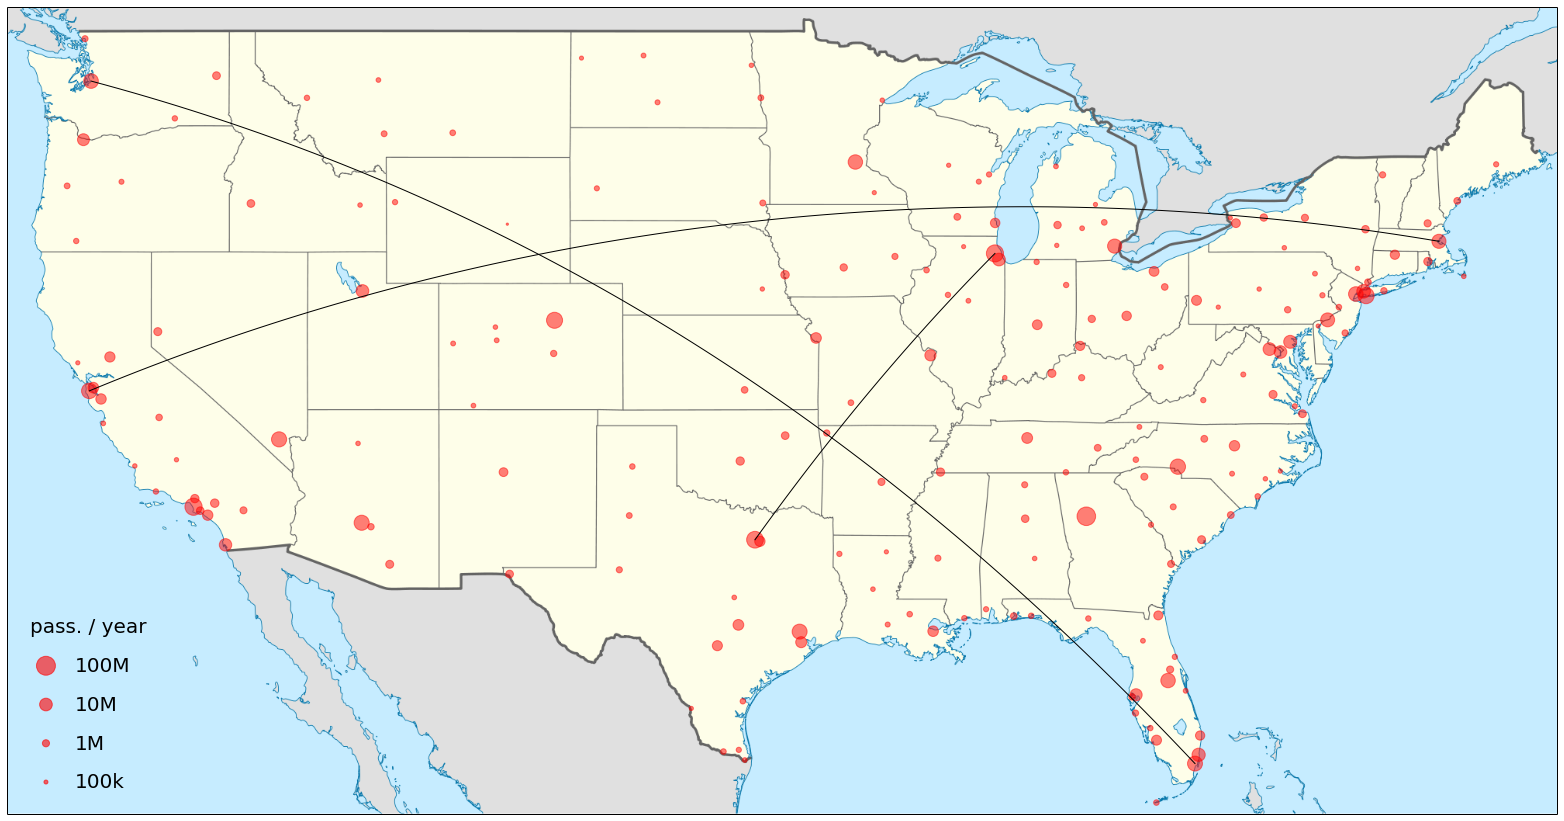

In [541]:
## show the map
imgplot = plt.imshow(img)
plt.axes().xaxis.set_visible(False)
plt.axes().yaxis.set_visible(False)
## overlay the path between a few pairs of cities as examples
plt.plot(path_mapcoords[airportpair_key("SFO", "BOS")][0], path_mapcoords[airportpair_key("SFO", "BOS")][1], color = 'black')
plt.plot(path_mapcoords[airportpair_key("SEA", "MIA")][0], path_mapcoords[airportpair_key("SEA", "MIA")][1], color = 'black')
plt.plot(path_mapcoords[airportpair_key("ORD", "DFW")][0], path_mapcoords[airportpair_key("ORD", "DFW")][1], color = 'black')
## overlay airport locations
for airport in airports:
    coords = map_coords(airportcoords[airport])
    npassengers = airport_passengers[airport]
    markersize = 16 * np.sqrt(npassengers / 1e5)
    plt.scatter([coords[0]], [coords[1]], color = 'red', alpha = 0.5, s = markersize)
## add a legend
ms100M = 16 * np.sqrt(50e6 / 1e5)
ms10M = 16 * np.sqrt(10e6 / 1e5)
ms1M = 16 * np.sqrt(1e6 / 1e5)
ms100k = 16 * np.sqrt(1e5 / 1e5)
plt.scatter([50, 50, 50, 50], [850, 900, 950, 1000], color = 'red', alpha = 0.6, s = [ms100M, ms10M, ms1M, ms100k])
plt.text(30, 808, "pass. / year", fontsize=20)
plt.text(90, 858, "100M", fontsize=20)
plt.text(90, 908, "10M", fontsize=20)
plt.text(90, 958, "1M", fontsize=20)
plt.text(90, 1008, "100k", fontsize=20)
## set plot range
plt.axes().set_xlim([0, 2000])
plt.axes().set_ylim([1041, 0])
plt.savefig("map_airports.png", bbox_inches='tight')

In [547]:
# function to plot a box
def plot_box(long_limits, lat_limits):
    [x1, x2] = long_limits
    [y1, y2] = lat_limits
    plt.plot((map_coords([x1, y1])[0], map_coords([x2, y1])[0]), (map_coords([x1, y1])[1], map_coords([x2, y1])[1]), 'b-', linewidth = 3)
    plt.plot((map_coords([x1, y1])[0], map_coords([x1, y2])[0]), (map_coords([x1, y1])[1], map_coords([x1, y2])[1]), 'b-', linewidth = 3)
    plt.plot((map_coords([x1, y2])[0], map_coords([x2, y2])[0]), (map_coords([x1, y2])[1], map_coords([x2, y2])[1]), 'b-', linewidth = 3)
    plt.plot((map_coords([x2, y1])[0], map_coords([x2, y2])[0]), (map_coords([x2, y1])[1], map_coords([x2, y2])[1]), 'b-', linewidth = 3)

In [312]:
# boxes partitioning space
boxes = [[[-126, -121], [44, 49]], [[-121, -116], [44, 49]], [[-116, -111], [44, 49]], \
         [[-111, -106], [44, 49]], [[-106, -101], [44, 49]], [[-101, -96], [44, 49]], \
         [[-96, -91], [44, 49]], [[-124, -116], [40, 44]], [[-116, -111], [40, 44]], \
         [[-111, -106], [40, 44]], [[-106, -101], [40, 44]], [[-101, -96], [40, 44]], \
         [[-96, -91], [40, 44]], [[-124, -116], [36, 40]], [[-116, -111], [36, 40]], \
         [[-111, -106], [36, 40]], [[-106, -101], [36, 40]], [[-101, -96], [36, 40]], \
         [[-96, -91], [36, 40]], [[-121, -116], [31, 36]], [[-116, -111], [31, 36]], \
         [[-111, -106], [31, 36]], [[-106, -101], [29, 36]], [[-101, -96], [26, 36]], \
         [[-96, -91], [29, 36]], [[-91, -86], [40, 47]], [[-86, -81], [40, 45]], \
         [[-81, -75], [40, 45]], [[-75, -69], [40, 45]], [[-91, -86], [35, 40]], \
         [[-86, -81], [35, 40]], [[-81, -75], [35, 40]], [[-91, -86], [30, 35]], \
         [[-86, -79], [25, 35]]]

In [529]:
# boxes partitioning space
boxes = [[[-124, -116], [40, 49]], [[-116, -106], [40, 49]], \
         [[-106, -96], [40, 49]], [[-96, -91], [44, 49]], \
         [[-96, -91], [40, 44]], [[-124, -116], [36, 40]], [[-116, -111], [36, 40]], \
         [[-111, -106], [36, 40]], [[-106, -101], [36, 40]], [[-101, -96], [36, 40]], \
         [[-96, -91], [36, 40]], [[-121, -116], [31, 36]], [[-116, -111], [31, 36]], \
         [[-111, -106], [31, 36]], [[-106, -101], [29, 36]], [[-101, -96], [29, 36]], \
         [[-96, -91], [29, 36]], [[-91, -86], [40, 47]], [[-86, -81], [40, 45]], \
         [[-81, -75], [40, 45]], [[-75, -69], [40, 45]], [[-91, -86], [35, 40]], \
         [[-86, -81], [35, 40]], [[-81, -75], [35, 40]], [[-91, -86], [30, 35]], \
         [[-86, -79], [25, 35]]]

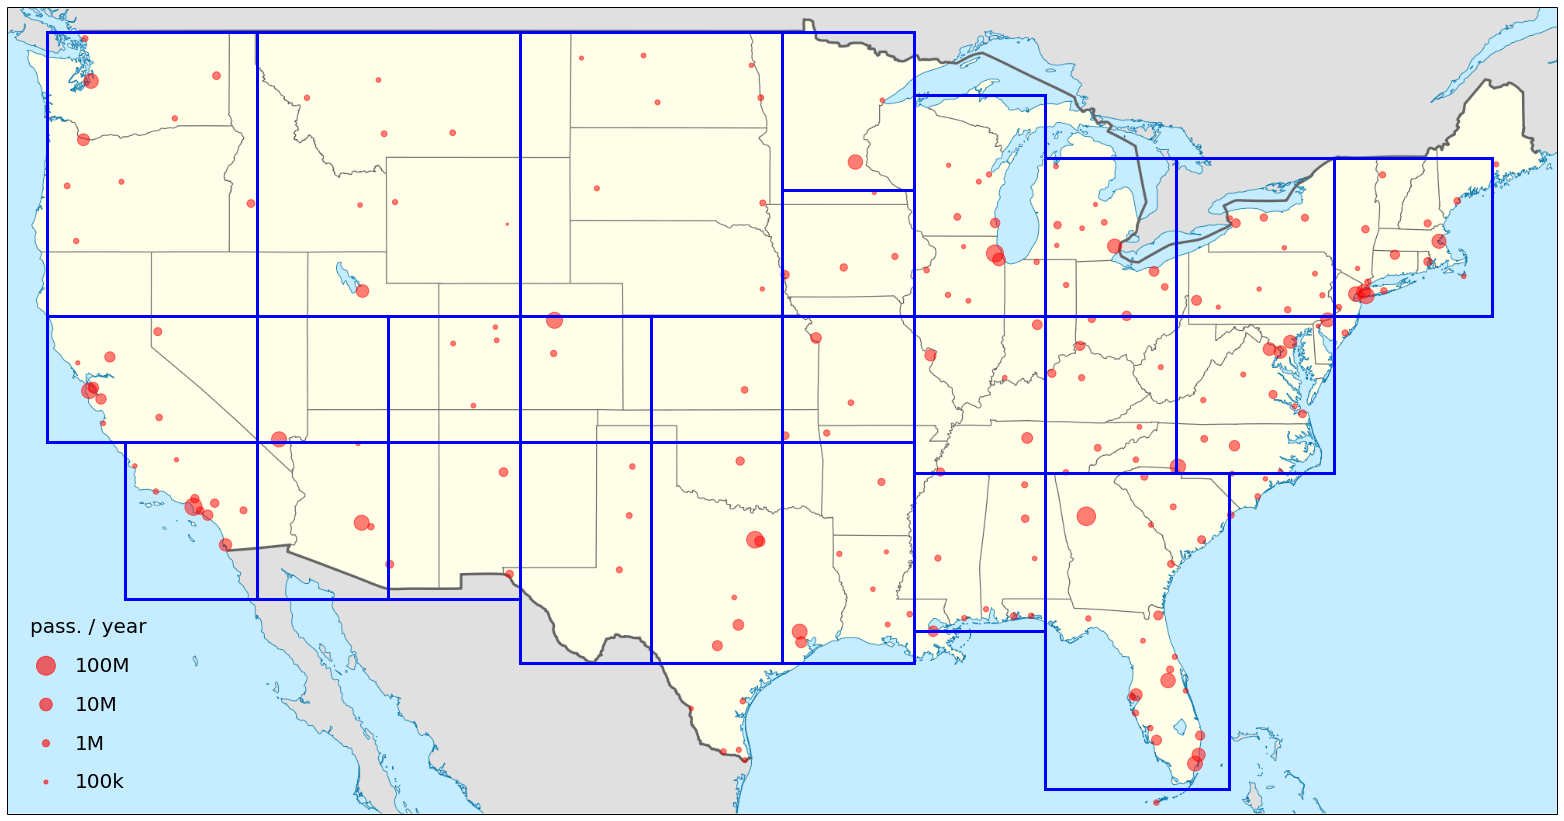

In [548]:
## show the map
imgplot = plt.imshow(img)
plt.axes().xaxis.set_visible(False)
plt.axes().yaxis.set_visible(False)
## overlay a grid of boxes in which we'll determine the wind speed
for box in boxes:
    plot_box(box[0], box[1])
## overlay airport locations
for airport in airports:
    coords = map_coords(airportcoords[airport])
    npassengers = airport_passengers[airport]
    markersize = 16 * np.sqrt(npassengers / 100000)
    plt.scatter([coords[0]], [coords[1]], color = 'red', alpha = 0.5, s = markersize)
## add a legend
ms100M = 16 * np.sqrt(50e6 / 1e5)
ms10M = 16 * np.sqrt(10e6 / 1e5)
ms1M = 16 * np.sqrt(1e6 / 1e5)
ms100k = 16 * np.sqrt(1e5 / 1e5)
plt.scatter([50, 50, 50, 50], [850, 900, 950, 1000], color = 'red', alpha = 0.6, s = [ms100M, ms10M, ms1M, ms100k])
plt.text(30, 808, "pass. / year", fontsize=20)
plt.text(90, 858, "100M", fontsize=20)
plt.text(90, 908, "10M", fontsize=20)
plt.text(90, 958, "1M", fontsize=20)
plt.text(90, 1008, "100k", fontsize=20)
## set plot range
plt.axes().set_xlim([0, 2000])
plt.axes().set_ylim([1041, 0])
plt.savefig("map_boxes.png", bbox_inches='tight')

# get the flight data

## SQL databases built from .csv files (from website at the top)
## flights database fields:
## Year, Month, DayofMonth, DayOfWeek, DepTime, CRSDepTime, ArrTime, CRSArrTime, UniqueCarrier, FlightNum, TailNum, ActualElapsedTime, CRSElapsedTime, AirTime, ArrDelay, DepDelay, Origin, Dest, Distance, TaxiIn, TaxiOut, Cancelled, CancellationCode, Diverted, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay

In [4]:
## total number of flights in the database
sqlExec("SELECT COUNT(*) FROM flights")

[{u'COUNT(*)': 35874731}]

In [17]:
## pull flights from the database
## Jet Blue flights (UniqueCarrier = 'B6') often have the wrong time zone for the origin or destination, so we drop this data
flights = sqlExec("SELECT Origin,Dest,Distance,AirTime FROM flights WHERE Origin IN "+sqlsetairports+" AND Dest IN "+sqlsetairports+" AND Cancelled = 0 AND Diverted = 0 AND UniqueCarrier != \"B6\"")
print "Total of "+str(len(flights))+" flights"

Total of 32416717 flights


## group flights by origin/destination, calculate speed of each flight

In [18]:
## key function: generate string from two airport names to represent pair
def airportpair_key(A,B):
    return A+"_"+B

In [19]:
## dictionary to store speeds between airport pairs
speeds = {}
for A in airports:
    for B in airports:
        if A != B:
            speeds[airportpair_key(A,B)] = []

### loop over all flights and compute the speed, store in dictionary

In [20]:
nflights = 0
for flight in flights:
    A = flight["Origin"]
    B = flight["Dest"]
    dist = flight["Distance"] # distance is in miles
    time = flight["AirTime"]/60 # convert time to hours
    # check the time is nonzero
    if time > 0:
        speed = dist / time
        speeds[airportpair_key(A,B)].append(speed)
    else:
        nflights+=1
print str(nflights)+" flights with time = 0"

18115 flights with time = 0


In [569]:
## function to display a plot of speeds between any two cities
## displays both A -> B and B -> A speeds, along with the (approximate) speed of sound
def plot_speeds(A, B):
    soundspeed = 660 # mph, at altitude ~35000 ft
    ## make plot of speeds and save
    fig = plt.figure(figsize=(9,6))
    ## set plot range, bins
    xmin = 0
    xmax = soundspeed * 1.1
    bins = np.linspace(xmin, xmax, 51)
    plt.xlim([xmin, xmax])
    plt.xlabel('speed [mph]', fontsize = 14)
    plt.ylabel('number of flights', fontsize = 14)
    ## histogram
    plt.hist(speeds[airportpair_key(A,B)], bins, facecolor='green', alpha=0.5, label=A+' to '+B)
    plt.hist(speeds[airportpair_key(B,A)], bins, facecolor='blue', alpha=0.5, label=B+' to '+A)
    plt.legend(loc='upper right')
    ## label the plot with the single event and its score
    ymax = 1.25*plt.axes().get_ylim()[1]
    plt.ylim([0,ymax])
    plt.axes().arrow(soundspeed, 0.12*ymax, 0, -0.09*ymax, head_width=0.015*(xmax - xmin), head_length=0.03*ymax, fc='r', ec='r')
    plt.show()
    plt.savefig("speeds_"+A+"_"+B+".png")
    return fig

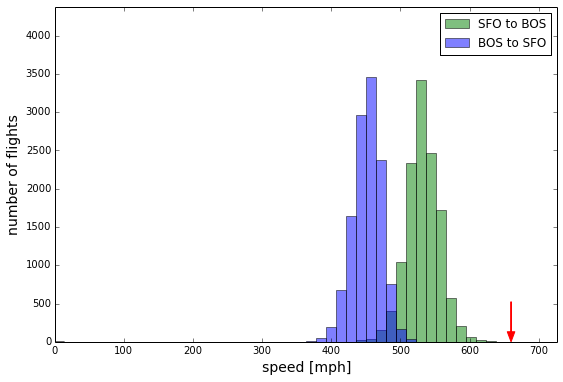

In [571]:
## example: San Francisco <-> Boston
fig = plot_speeds("SFO","BOS")
fig.savefig("speeds_SFO_BOS.png", bbox_inches='tight')

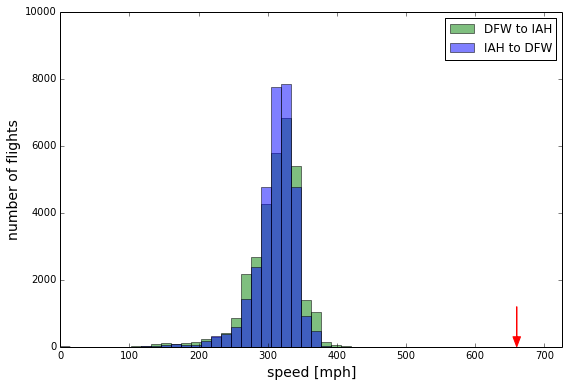

In [572]:
## example: Dallas <-> Houston
fig = plot_speeds("DFW","IAH")
fig.savefig("speeds_DFW_IAH.png", bbox_inches='tight')

In [422]:
## calculate the mean windspeed between airport pairs
vbarspeeds = []
for i in range(len(airports)):
    for j in range(i+1,len(airports)):
        A = airports[i]
        B = airports[j]
        # only allow city pairs with more than 100 flights each way
        if len(speeds[airportpair_key(A,B)]) > 100 and len(speeds[airportpair_key(B,A)]) > 100:
            AtoBspeed = np.mean(speeds[airportpair_key(A,B)])
            BtoAspeed = np.mean(speeds[airportpair_key(B,A)])
            vbar = 0.5 * (AtoBspeed - BtoAspeed)
            vbarspeeds.append([A, B, vbar])

In [423]:
# number of all distinct airport pairs
print len(airports) * (len(airports) - 1) / 2
# number of airport pairs with flights between them
print len(vbarspeeds)
print len(vbarspeeds) / (len(airports) * (len(airports) - 1) / 2)

20503.0
2334
0.113836999463


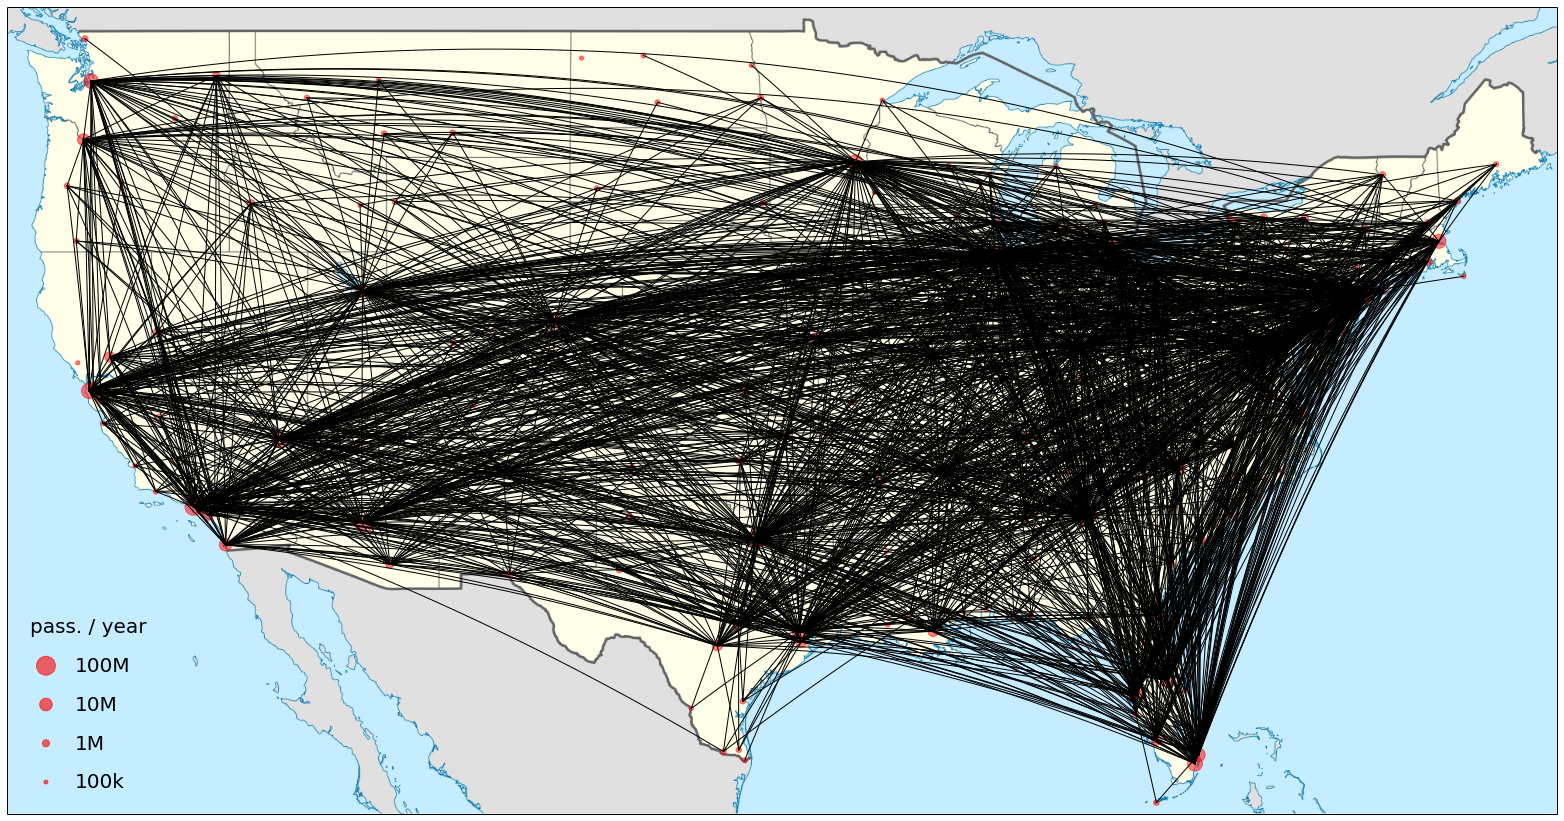

In [532]:
## show the map
imgplot = plt.imshow(img)
plt.axes().xaxis.set_visible(False)
plt.axes().yaxis.set_visible(False)
## overlay the path between a few pairs of cities as examples
for path in vbarspeeds:
    plt.plot(path_mapcoords[airportpair_key(path[0], path[1])][0], path_mapcoords[airportpair_key(path[0], path[1])][1], color = 'black')
## overlay airport locations
for airport in airports:
    coords = map_coords(airportcoords[airport])
    npassengers = airport_passengers[airport]
    markersize = 16 * np.sqrt(npassengers / 100000)
    plt.scatter([coords[0]], [coords[1]], color = 'red', alpha = 0.5, s = markersize)
## add a legend
ms100M = 16 * np.sqrt(50e6 / 1e5)
ms10M = 16 * np.sqrt(10e6 / 1e5)
ms1M = 16 * np.sqrt(1e6 / 1e5)
ms100k = 16 * np.sqrt(1e5 / 1e5)
plt.scatter([50, 50, 50, 50], [850, 900, 950, 1000], color = 'red', alpha = 0.6, s = [ms100M, ms10M, ms1M, ms100k])
plt.text(30, 808, "pass. / year", fontsize=20)
plt.text(90, 858, "100M", fontsize=20)
plt.text(90, 908, "10M", fontsize=20)
plt.text(90, 958, "1M", fontsize=20)
plt.text(90, 1008, "100k", fontsize=20)
## set plot range
plt.axes().set_xlim([0, 2000])
plt.axes().set_ylim([1041, 0])
plt.savefig("map_allpaths.png", bbox_inches='tight')

In [314]:
## compute box fractions and path directions in latitude-longitude space
def boxfractions(coords1, coords2, boxes):
    """Computes the fraction of total distance of a geodesic path in a given latitude-longitude box.  Returns the distance fractions in the path for each box."""
    [long1, lat1] = coords1
    [long2, lat2] = coords2
    ## counter for each box
    boxpts = [0 for n in range(len(boxes))]
    ## loop over steps in t, use parametric function of geodesic path
    nsteps = 99
    for nstep in range(nsteps+1):
        ## get t value and latitude, longitude
        tval = nstep * 1. / nsteps
        [longt, latt] = greatCircleFunc(coords1, coords2, tval)
        ## loop over boxes
        for nbox in range(len(boxes)):
            ## check if our point is in the box
            if boxes[nbox][0][0] < longt < boxes[nbox][0][1] and boxes[nbox][1][0] < latt < boxes[nbox][1][1]:
                boxpts[nbox] += 1./(nsteps+1)
    return boxpts

# calculate the jet stream velocity in each box
## we are performing the least squares minimization for M.vJ = vbar, to find vJ
## where vJ are the components of wind speed velocity it latitude/longitude coordinates
## and vbar is the average wind speed for each path

In [428]:
## construct vbar
vbar = [vbarspeed[2] for vbarspeed in vbarspeeds]

In [533]:
## construct M
## for each path, we record the longitude then latitude components
rows = []
for path in vbarspeeds:
    [long1, lat1] = airportcoords[path[0]]
    [long2, lat2] = airportcoords[path[1]]
    boxfracs = boxfractions(airportcoords[path[0]], airportcoords[path[1]], boxes)
    ## here we approximate the direction of travel in each box as a straight line in latitude-longitude space
    ## this is a reasonable approximation for the direction
    rhatlat = (lat2 - lat1) / np.sqrt((lat2 - lat1)*(lat2 - lat1) + (long2 - long1)*(long2 - long1))
    rhatlong = (long2 - long1) / np.sqrt((lat2 - lat1)*(lat2 - lat1) + (long2 - long1)*(long2 - long1))
    row = []
    for frac in boxfracs:
        row.append(rhatlong * frac)
        row.append(rhatlat * frac)
    rows.append(row)
M = np.matrix(rows)

In [534]:
## now find vJ
Mlsm = np.array(np.dot(np.linalg.inv(np.dot(np.transpose(M), M)),np.transpose(M)))
vJ = np.dot(Mlsm, vbar)

In [535]:
# get velocities (index by the box) and magnitudes (sorted)
vJvecs = []
vJvals = []
for n in range(len(boxes)):
    vJvecs.append([vJ[2*n], vJ[2*n+1]])
    vJvals.append(np.sqrt(vJ[2*n]*vJ[2*n] + vJ[2*n+1]*vJ[2*n+1]))
vJvals = np.sort(vJvals)
print vJvals

[  2.56044276  17.74661322  19.60540706  21.14189975  21.331083
  22.30246588  22.73879209  23.06366098  24.77556826  27.09761998
  27.38227655  28.73655967  28.84714884  28.89671883  31.28802075
  32.50970606  32.98053672  33.85089445  35.57942462  36.69965855
  36.76162278  41.02272242  42.62651613  47.24704901  53.30943185
  60.79835522]


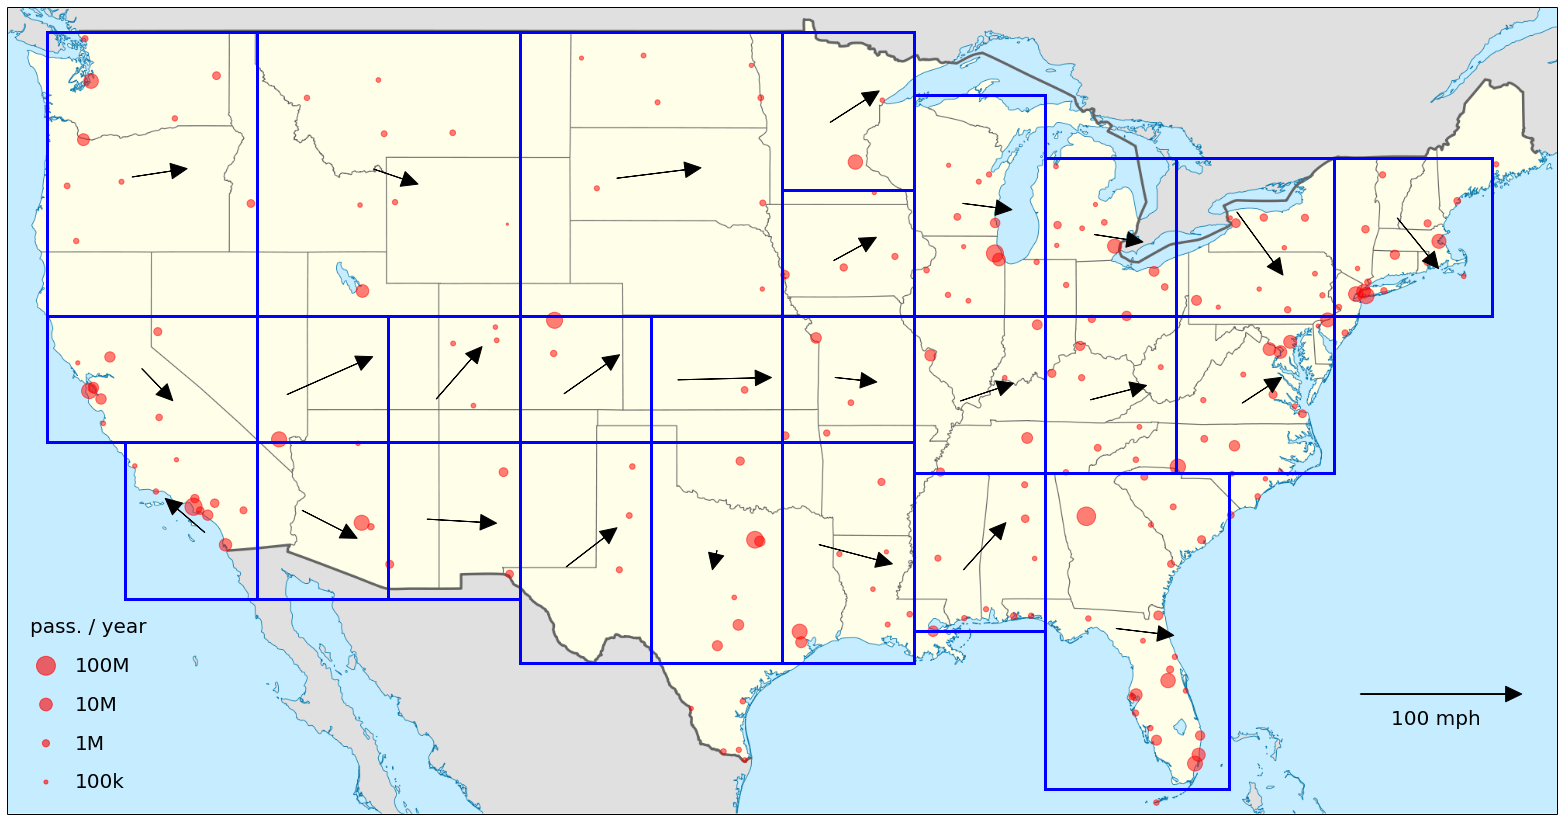

In [550]:
## create the map
imgplot = plt.imshow(img)
plt.axes().xaxis.set_visible(False)
plt.axes().yaxis.set_visible(False)
## overlay airport locations
for airport in airports:
    coords = map_coords(airportcoords[airport])
    npassengers = airport_passengers[airport]
    markersize = 16 * np.sqrt(npassengers / 100000)
    plt.scatter([coords[0]], [coords[1]], color = 'red', alpha = 0.5, s = markersize)
## overlay a grid of boxes in which we'll determine the wind speed
for box in boxes:
    plot_box(box[0], box[1])
## now add arrows for each box
for nbox in range(len(boxes)):
    [boxlong, boxlat] = map_coords([np.mean(boxes[nbox][0]), np.mean(boxes[nbox][1])])
    ## now get the velocity vector
    vJlong = vJvecs[nbox][0]
    vJlat = vJvecs[nbox][1]
    vJpt = np.sqrt(vJlat*vJlat + vJlong*vJlong)
    rJlat = (vJlat / vJpt) * min((vJpt / vJvals[-2]), 1) * 100.
    rJlong = (vJlong / vJpt) * min((vJpt / vJvals[-2]), 1) * 100.
    ## add the arrow
    ## we normalize the arrow to have at most 100 pixels in length
    ## and we center the arrow in the box
    shift_long = 0.5*rJlong
    shift_lat = 0.5*rJlat
    plt.axes().arrow(boxlong - shift_long, boxlat - shift_lat, rJlong, rJlat, head_width=0.01*2000, head_length=0.02*1041, fc='black', ec='black')
## add a legend
[leglong, leglat] = map_coords([-74, 28])
rLlat = 0
rLlong = (100 / vJvals[-2]) * 100.
plt.axes().arrow(leglong, leglat, rLlong, rLlat, head_width=0.01*2000, head_length=0.02*1041, fc='black', ec='black')
plt.text(leglong + 40, leglat + 40, "100 mph", fontsize=20)
## add a legend
ms100M = 16 * np.sqrt(50e6 / 1e5)
ms10M = 16 * np.sqrt(10e6 / 1e5)
ms1M = 16 * np.sqrt(1e6 / 1e5)
ms100k = 16 * np.sqrt(1e5 / 1e5)
plt.scatter([50, 50, 50, 50], [850, 900, 950, 1000], color = 'red', alpha = 0.6, s = [ms100M, ms10M, ms1M, ms100k])
plt.text(30, 808, "pass. / year", fontsize=20)
plt.text(90, 858, "100M", fontsize=20)
plt.text(90, 908, "10M", fontsize=20)
plt.text(90, 958, "1M", fontsize=20)
plt.text(90, 1008, "100k", fontsize=20)
## set plot range
plt.axes().set_xlim([0, 2000])
plt.axes().set_ylim([1041, 0])
plt.savefig("map_windspeed.png", bbox_inches='tight')

## compare the least squares value for the velocities with the measured ones, path-by-path

In [458]:
# for each path, compute the velocity in that path using boxes
vmeas = []
for path in vbarspeeds:
    ## find the distance fraction in each box
    [long1, lat1] = airportcoords[path[0]]
    [long2, lat2] = airportcoords[path[1]]
    boxfracs = boxfractions(airportcoords[path[0]], airportcoords[path[1]], boxes)
    ## we find the total path length in any box, since some flight paths cross out of boxes
    ## we'll normalize by this total path length
    totfrac = np.sum(boxfracs)
    ## here we approximate the direction of travel in each box as a straight line in latitude-longitude space
    ## this is a reasonable approximation for the direction
    rhatlat = (lat2 - lat1) / np.sqrt((lat2 - lat1)*(lat2 - lat1) + (long2 - long1)*(long2 - long1))
    rhatlong = (long2 - long1) / np.sqrt((lat2 - lat1)*(lat2 - lat1) + (long2 - long1)*(long2 - long1))
    ## now loop over all boxes
    ## dot the jet stream velocity into the path and sum
    vpath = 0
    for nbox in range(len(boxes)):
        vJlong = vJvecs[nbox][0]
        vJlat = vJvecs[nbox][1]
        boxfrac = boxfracs[nbox] / totfrac
        vpath += boxfrac * (vJlong * rhatlong + vJlat * rhatlat)
    ## save the path velocity as measured from vJ along with the vbar value measured from the flight data
    vmeas.append([path[0], path[1], path[2], vpath])

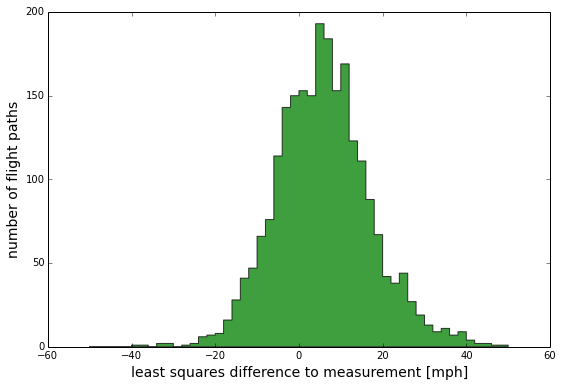

In [576]:
## histogram the speed differences
vmeasdiff = [path[2] - path[3] for path in vmeas]
fig = plt.figure(figsize=(9,6))
n, bins, patches = plt.hist(vmeasdiff, bins = 50, range=[-50, 50], histtype='stepfilled')
plt.setp(patches, 'facecolor', 'g', 'alpha', 0.75)
plt.xlabel('least squares difference to measurement [mph]', fontsize=14)
plt.ylabel('number of flight paths', fontsize=14)
fig.savefig("speeds_diff.png", bbox_inches='tight')

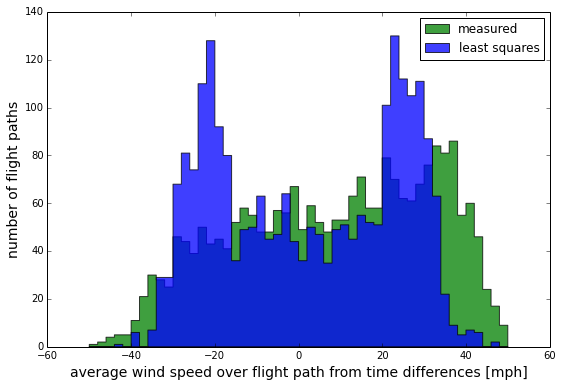

In [578]:
## histogram the measured speeds
vmeas_bar = [path[2] for path in vmeas]
vmeas_map = [path[3] for path in vmeas]
fig = plt.figure(figsize=(9,6))
n, bins, patches = plt.hist(vmeas_bar, bins = 50, range=[-50, 50], histtype='stepfilled', label = 'measured')
plt.setp(patches, 'facecolor', 'g', 'alpha', 0.75)
n, bins, patches = plt.hist(vmeas_map, bins = 50, range=[-50, 50], histtype='stepfilled', label = 'least squares')
plt.setp(patches, 'facecolor', 'b', 'alpha', 0.75)
plt.legend(loc='upper right')
plt.xlabel('average wind speed over flight path from time differences [mph]', fontsize=14)
plt.ylabel('number of flight paths', fontsize=14)
fig.savefig("speeds_comp.png", bbox_inches='tight')

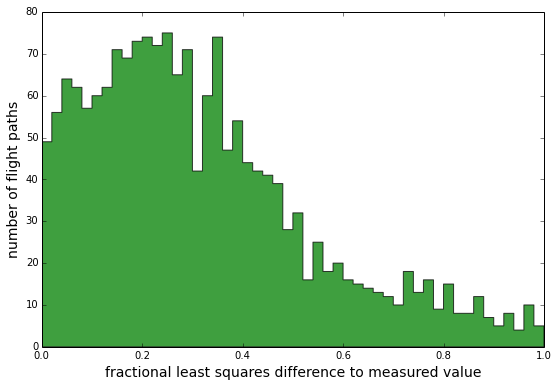

In [579]:
## histogram the speed differences
vmeasdiff_frac = [np.abs(path[3] / path[2] - 1) for path in vmeas]
fig = plt.figure(figsize=(9,6))
n, bins, patches = plt.hist(vmeasdiff_frac, bins = 50, range=[0, 1], histtype='stepfilled')
plt.setp(patches, 'facecolor', 'g', 'alpha', 0.75)
plt.xlabel('fractional least squares difference to measured value', fontsize=14)
plt.ylabel('number of flight paths', fontsize=14)
fig.savefig("speeds_fracdiff.png", bbox_inches='tight')

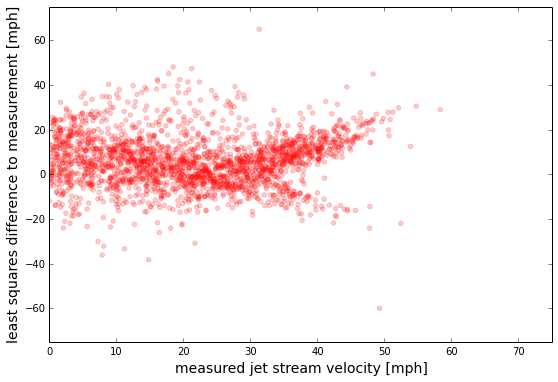

In [584]:
## scatter plot of the speed differences vs the speeds
vbarspeedvals = [np.abs(path[2]) for path in vmeas]
vmeasdiff = [path[2] - path[3] for path in vmeas]
fig = plt.figure(figsize=(9,6))
plt.scatter(vbarspeedvals, vmeasdiff, color = 'r', alpha = 0.2)
plt.axes().set_xlim([0,75])
plt.axes().set_ylim([-75,75])
plt.xlabel('measured jet stream velocity [mph]', fontsize=14)
plt.ylabel('least squares difference to measurement [mph]', fontsize=14)
fig.savefig("speeds_diff_vs_speed.png", bbox_inches='tight')

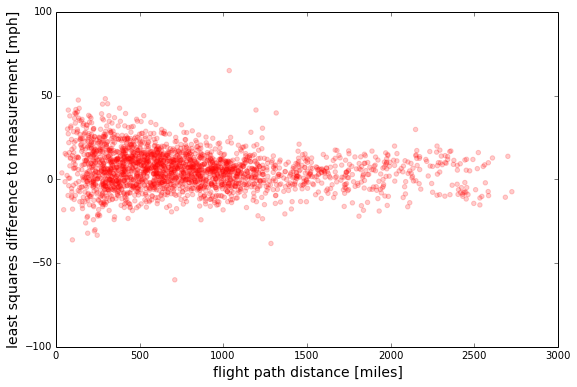

In [585]:
## scatter plot of the speed differences vs the distance of the flight
pathdistances = [geodesicDist(airportcoords[path[0]], airportcoords[path[1]]) for path in vmeas]
vmeasdiff = [path[2] - path[3] for path in vmeas]
fig = plt.figure(figsize=(9,6))
plt.scatter(pathdistances, vmeasdiff, color = 'r', alpha = 0.2)
plt.axes().set_xlim([0,3000])
plt.axes().set_ylim([-100,100])
plt.xlabel('flight path distance [miles]', fontsize=14)
plt.ylabel('least squares difference to measurement [mph]', fontsize=14)
fig.savefig("speeds_diff_vs_dist.png", bbox_inches='tight')

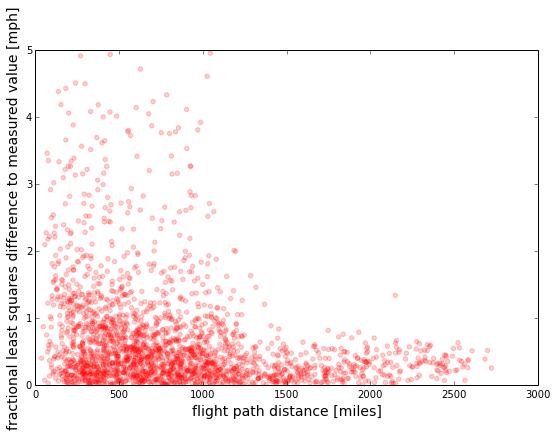

In [586]:
## scatter plot of the speed differences vs the distance of the flight
pathdistances = [geodesicDist(airportcoords[path[0]], airportcoords[path[1]]) for path in vmeas]
vmeasdiff_frac = [np.abs(path[2] / path[3] - 1) for path in vmeas]
fig = plt.figure(figsize=(9,6))
plt.scatter(pathdistances, vmeasdiff_frac, color = 'r', alpha = 0.2)
plt.axes().set_xlim([0,3000])
plt.axes().set_ylim([0,5])
plt.xlabel('flight path distance [miles]', fontsize=14)
plt.ylabel('fractional least squares difference to measured value [mph]', fontsize=14)
fig.savefig("speeds_fracdiff_vs_dist.png", bbox_inches='tight')

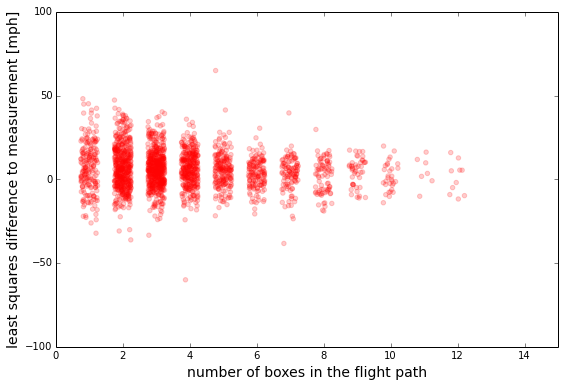

In [587]:
## scatter plot of the speed differences vs the number of boxes in the path
nboxes_scatter = []
for path in vmeas:
    boxfracs = boxfractions(airportcoords[path[0]], airportcoords[path[1]], boxes)
    nboxes_scatter.append(np.sum([1 for frac in boxfracs if frac > 0]) + 0.25 * (2*np.random.random() - 1))
vmeasdiff = [path[2] - path[3] for path in vmeas]
fig = plt.figure(figsize=(9,6))
plt.scatter(nboxes_scatter, vmeasdiff, color = 'r', alpha = 0.2)
plt.axes().set_xlim([0,15])
plt.axes().set_ylim([-100,100])
plt.xlabel('number of boxes in the flight path', fontsize=14)
plt.ylabel('least squares difference to measurement [mph]', fontsize=14)
fig.savefig("speeds_diff_vs_nboxes.png", bbox_inches='tight')

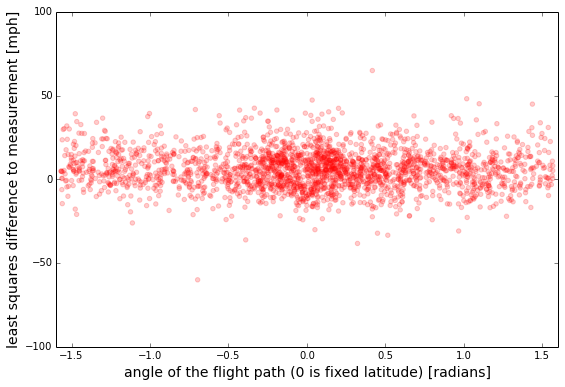

In [588]:
## scatter plot of the speed differences vs the flight path direction
## angle of 0 is fixed latitude travel (approximating the path as straight in latitude/longitude coordinates)
pathangle = []
for path in vmeas:
    [long1, lat1] = airportcoords[path[0]]
    [long2, lat2] = airportcoords[path[1]]
    pathangle.append(np.arctan((lat2 - lat1) / (long2 - long1)))
vmeasdiff = [path[2] - path[3] for path in vmeas]
fig = plt.figure(figsize=(9,6))
plt.scatter(pathangle, vmeasdiff, color = 'r', alpha = 0.2)
plt.axes().set_xlim([-1.6,1.6])
plt.axes().set_ylim([-100,100])
plt.xlabel('angle of the flight path (0 is fixed latitude) [radians]', fontsize=14)
plt.ylabel('least squares difference to measurement [mph]', fontsize=14)
fig.savefig("speeds_diff_vs_angle.png", bbox_inches='tight')